# Exercise 11: Visual Odometry

In [1]:
# Imports
from scipy.spatial.transform import Rotation
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys 
import os
import seaborn as sns

sns.set_theme(palette=sns.color_palette("twilight_shifted"))
os.getcwd()

'c:\\Users\\G531\\Documents\\8 - Github\\ComputerVision\\11 - Visual Odometry'

In [2]:
# Functions for visualization
def plot(img, size=6):
    fig, ax = plt.subplots(1, figsize=(size,size))
    ax.imshow(img, cmap='gray')
    plt.grid(False)
    plt.show()

def plot_multi(imgarr):
    fig, axarr = plt.subplots(1, len(imgarr), figsize=(6*len(imgarr), 6))
    for img, ax in zip(imgarr, axarr):
        ax.imshow(img, cmap='gray')
        ax.grid(False) 

    plt.show()

In [4]:
# Load camera matrix
K = np.loadtxt('K.txt')
K

array([[3.1174740e+03, 0.0000000e+00, 1.5019408e+03],
       [0.0000000e+00, 3.1174740e+03, 9.8476840e+02],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]])

(2000, 3008) (2000, 3008) (2000, 3008)


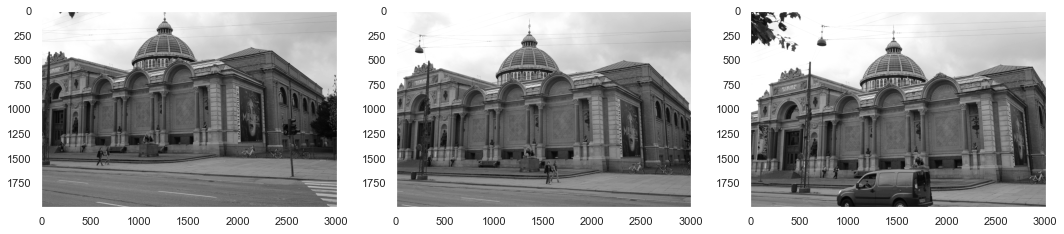

In [5]:
# Load first 3 images
im0 = cv2.imread("./sequence/000001.png", cv2.IMREAD_GRAYSCALE) 
im1 = cv2.imread("./sequence/000002.png", cv2.IMREAD_GRAYSCALE) 
im2 = cv2.imread("./sequence/000003.png", cv2.IMREAD_GRAYSCALE) 

print(im0.shape, im1.shape, im2.shape)
plot_multi([im0, im1, im2])

### Exercise 11.1

In [6]:
# SIFT detector
sift = cv2.SIFT_create(nfeatures=2020)

kp0, des0 = sift.detectAndCompute(im0, None)
kp1, des1 = sift.detectAndCompute(im1, None)
kp2, des2 = sift.detectAndCompute(im2, None)

keypoints0 = np.array([k.pt for k in kp0])
keypoints1 = np.array([k.pt for k in kp1])
keypoints2 = np.array([k.pt for k in kp2])

keypoints0.shape, keypoints1.shape, keypoints2.shape

((2020, 2), (2020, 2), (2020, 2))

In [7]:
# Matches
bf = cv2.BFMatcher()
mat01 = bf.knnMatch(des0, des1, k=2)
mat12 = bf.knnMatch(des1, des2, k=2)

matches01 = np.array([(m.queryIdx, m.trainIdx) for m, _ in mat01])
matches12 = np.array([(m.queryIdx, m.trainIdx) for m, _ in mat12])

matches01.shape, matches12.shape

((2020, 2), (2020, 2))

### Exercise 11.2

In [8]:
# Estimate essential matrix
E, _ = cv2.findEssentialMat(keypoints0, keypoints1, cameraMatrix=K, method=cv2.RANSAC)
E

array([[-0.03649002,  0.70222192,  0.06979473],
       [-0.64046474, -0.00895499, -0.28225728],
       [-0.09317976,  0.02492529, -0.03785981]])

In [9]:
# Decompose essential matrix and find the correct relative pose (R1, t1)
_, R1, t1, mask_pose = cv2.recoverPose(E, keypoints0, keypoints1)

R1, t1

(array([[ 9.29412373e-01,  1.16342543e-02,  3.68859437e-01],
        [ 7.38502722e-04,  9.99442314e-01, -3.33843692e-02],
        [-3.69042131e-01,  3.13002495e-02,  9.28885461e-01]]),
 array([[-0.03692017],
        [-0.14181363],
        [ 0.98920463]]))

In [10]:
# Keep matches that are inliers (lie in front of both cameras)
matches01_inliers = matches01[mask_pose[:, 0].astype(bool)]
matches01_inliers.shape

(2019, 2)

### Exercise 11.3

In [11]:
# Intersection of the matches from img0-img1 and matches from img1-img2
_, idx01, idx12 = np.intersect1d(matches01_inliers[:,1], matches12[:,0], return_indices=True)

idx01.shape, idx12.shape

((1287,), (1287,))

In [12]:
# Matches from the intersection
intersection01 = matches01_inliers[idx01]
intersection12 = matches12[idx12]

intersection01.shape, intersection12.shape

((1287, 2), (1287, 2))

In [13]:
# List of 2D points locations of the same point in the corresponding images
points0 = keypoints0[intersection01[:, 0], :]
points1a = keypoints1[intersection01[:, 1], :]

points1b = keypoints1[intersection12[:, 0], :]
points2 = keypoints2[intersection12[:, 1], :]

points0.shape, points1a.shape, points1b.shape, points2.shape

((1287, 2), (1287, 2), (1287, 2), (1287, 2))

### Exercise 11.4

In [14]:
# R and t from image 0
R0 = np.identity(3)
t0 = np.array([[0], [0], [0]])
R0, t0

(array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]),
 array([[0],
        [0],
        [0]]))

In [15]:
# Projection matrix 0
P0 = K @ np.column_stack((R0, t0))
P0.shape, P0

((3, 4),
 array([[3.1174740e+03, 0.0000000e+00, 1.5019408e+03, 0.0000000e+00],
        [0.0000000e+00, 3.1174740e+03, 9.8476840e+02, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00]]))

In [16]:
# R and t from image 1
R1, t1

(array([[ 9.29412373e-01,  1.16342543e-02,  3.68859437e-01],
        [ 7.38502722e-04,  9.99442314e-01, -3.33843692e-02],
        [-3.69042131e-01,  3.13002495e-02,  9.28885461e-01]]),
 array([[-0.03692017],
        [-0.14181363],
        [ 0.98920463]]))

In [17]:
# Projection matrix 1
P1 = K @ np.column_stack((R1, t1))
P1.shape, P1

((3, 4),
 array([[ 2.34313948e+03,  8.32806070e+01,  2.54504068e+03,
          1.37062913e+03],
        [-3.61118766e+02,  3.14655892e+03,  8.10662146e+02,
          5.32037141e+02],
        [-3.69042131e-01,  3.13002495e-02,  9.28885461e-01,
          9.89204627e-01]]))

Prepare points and create list of P's for triangulation

In [18]:
# Reshape points
points0_re = points0.T
points1a_re = points1a.T
points0_re.shape, points1a_re.shape

((2, 1287), (2, 1287))

In [19]:
# Tranform from inhomogeneous to homogeneous coordinates
def inh_to_h(points):
    # Convert to homogeneous appending a 1 to each point
    points = np.vstack([points, np.ones(points.shape[1])])

    return points

In [20]:
points0_h = inh_to_h(points0_re)
points0_h.shape

(3, 1287)

In [21]:
points1a_h = inh_to_h(points1a_re)
points1a_h.shape

(3, 1287)

In [22]:
# List of Projection matrices
P_list = np.array([P0, P1])
P_list.shape

(2, 3, 4)

Triangulation

In [23]:
def squeezdim(v):
    """
    Function that squeezes a vetor into a the form (n,)
    v: vector of dimension n.     
    """
    v = np.array(v)
    try:
        m,n = v.shape
    except ValueError:
        return v
    if m>n: 
        v = np.squeeze(v, axis=1)
    else:
        v = np.squeeze(v, axis=0)
    return v

In [24]:
def matrix_B_triangulation(q, P):
    """
    Creates  B matrix for Triangulation. Follows the next equation:
        qh = P*Q
    Where qh is a 2D point in homoogenous form [sx, sy, s], P is the Projection Matrix and Q it's a 3D point in homogenous
    coordinates [X, Y, Z, 1].
    We can rearange it as:
        s * [x, y].T = [p(1)*Q, p(2)*Q].T
    Where p(i) = row vector of P. P(1) = P[0,:] (1,3) and the scale s = p(3)*Q:
        0 = [p(3)*x-p(1), p(3)*y-p(2)].T*Q
    
    PARAMETERS
    q: Point in homogenous fom [sx, sy, s] -> (3,1)
    P: projection matrix K*[R t] -> (3,4)
    RETURNS
    B: B Matrix (2,4)
    """

    q = squeezdim(q)
    
    if q.shape != (3,):
        print('q is not in Homogenous form: ', q.shape)
        return False
    # Transform into inhomogeous form [x, y, 1] in case it's not in homogenous form. 
    q = q/q[-1]
    
    
    #  Extract parameters 
    x = q[0]
    y = q[1]
    p_1 = squeezdim(P[0,:])
    p_2 = squeezdim(P[1,:])
    p_3 = squeezdim(P[2,:])
    # Create B
    B = np.array([(p_3*x - p_1), (p_3*y-p_2)])
    
    return B

In [25]:
def triangulate(qs:list, P:list):
    """
    Find points in 3D given a set of points in 2D and the Cameras' Projection Matrices used to obtain those 2D points.
    Using Linear algorithm.
    Create a Matrix B fof (n*2,4) where n is the number of cameras. Check Triabngulate_B for further doc.
    One We have B we apply singular value decomposition.
        arg min||B*Q||_2
    Wehere we impose the constrain of:
        ||Q||_2 = 1
    To specify that Q hasn't to be 0.
    
    PARAMETERS
    qs: List of points in 2D points in homogenous from. Scale Matters. 
    P: List of Projection Matrix.
    
    RETURNS
    Q: Estimated point in 3D in Homogenous coordinates [X, Y, Z, 1]
    """
    
    # Check The same samount of points and cameras.
    if len(qs) != len(P):
        print('Different number of 2D points and Projection matrix.')
        return False
    
    # Get the number of cameras
    n = len(P)
    # Set step for the B matrix 
    step = 2

    # Initializate B
    B = np.zeros((step*n, 4))
    
    for p,q,i in zip(P,qs, range(0,n*step,step)):
        B[i:i+step] = matrix_B_triangulation(q,p)

    _,s,eigVec = np.linalg.svd(B)
    # Find Min 
    idx = np.where(s==min(s))
    # Select the eigenvector correspondent to the eigenvalue
    Q = eigVec[idx]
    
    return  Q

In [26]:
# Tranform from homogeneous to inhomogeneous coordinates
def h_to_inh(points):
    # Convert to inhomogeneous dividing each point by the last 
    # coordinate and then removing it 
    points = points[:-1] / points[-1:]

    return points

In [27]:
# 3D triangulated points
Q = []

for q0, q1 in zip(points0_h.T, points1a_h.T):
    
    q = triangulate([q0, q1], P_list)
    q = h_to_inh(q.T)
    Q.append(q[:, 0])

Q = np.array(Q)

---

In [28]:
# Takes a list of pixel coords and a list of projection matrices and returns the triangulation of the point
def triangulate2(q_list, P_list):
    B = []
    for q, P in zip(q_list, P_list):
        b1 = P[2] * q[0] - P[0]
        b2 = P[2] * q[1] - P[1]

        B.append([b1, b2])

    B = np.vstack(np.array(B))
    _, _, vh = np.linalg.svd(B)
    Q_triangulated = vh[-1]

    return Q_triangulated

In [29]:
# 3D triangulated points
Q2 = []

for q0, q1 in zip(points0, points1a):
    
    q = triangulate2(np.array([q0, q1]), P_list)
    q = h_to_inh(q)
    Q2.append(q)


Q2 = np.array(Q)

In [31]:
# PnP
_, rvec, tvec, inliers = cv2.solvePnPRansac(Q, points2, K, distCoeffs=np.zeros(5))
rvec, tvec, inliers, Q.shape

(array([[-2.00927016],
        [-2.11060691],
        [-0.31780277]]),
 array([[ 0.01680819],
        [ 0.05375593],
        [-0.31748457]]),
 None,
 (1287, 3))

---

In [32]:
# PnP
_, rvec, tvec, inliers = cv2.solvePnPRansac(Q, points2, K, distCoeffs=np.zeros(5))
rvec, tvec, inliers

(array([[-2.00927016],
        [-2.11060691],
        [-0.31780277]]),
 array([[ 0.01680819],
        [ 0.05375593],
        [-0.31748457]]),
 None)

AttributeError: 'NoneType' object has no attribute 'flatten'

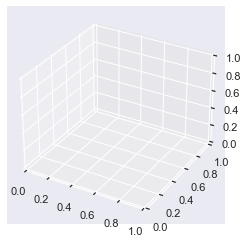

In [33]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(*Q[inliers.flatten()])